In [1]:
import numpy as np
import math
import pandas as pd
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates
from matplotlib import pyplot as plt

# Understanding vectorized databases
This section is to help me better understand and visualize linear queries and query workloads as vectors and matrices. I'll be using the example of a toy dataset and a few queries in Figure 2.1 from the [Li, et. al 2014 paper](https://people.cs.umass.edu/~mcgregor/papers/15-vldbj.pdf) to familiarize myself with working with these objects using numpy.

Load in the toy dataset from the paper's diagram about students' information as `toy`:

In [2]:
toy = pd.read_csv('toydataset.csv')
toy

,Name,Gradyear,Gender,Gpa
0,Alice,2012,F,3.8
1,Bob,2011,M,3.1
2,Charlie,2014,M,3.6
3,Dave,2014,M,3.3
4,Evelyn,2013,F,3.9
5,Frank,2011,M,3.2
6,Gary,2015,M,3.5


You can represent the above `toy` database as a vector __x__, where $x_i$ represents the counts of $\phi_i$ for i from 1 through 8. There are 8 spots because there are 4 levels for Gradyear and 2 levels for Gender; 4 * 2 = 8. 

Let R = (name, gradyear, gender, gpa) be the schema for the database. Each $\phi_i$ represents the schema for all M or F in a specific year. For instance, $\phi_1$ represents all the males in 2011, i.e. R(\*, 2011, M, \*), and $\phi_2$ represents all the women in 2011, i.e. R(*, 2011, F, *). 

__x__ is the vector representation of the above database:

In [3]:
x_toy = np.array([2, 0, 0, 1, 0, 1, 2, 0])

Each index has the counts for each schema corresponding to it (i.e., the year and gender pairing). 

Here is a workload of 5 queries, where $w_i$ represent different queries, such as: 

- $w_1$: Students of any gender with gradyear ∈ [2011, 2014]
- $w_2$: Students with gradyear ∈ [2011, 2012]
- $w_3$: Female students with gradyear ∈ [2011, 2012]
- $w_4$: Male students with gradyear ∈ [2011, 2012]
- $w_5$: Difference between 2013 grads and 2014 grads

Combine these queries into a workload matrix called `W_toy`:

In [4]:
W_toy = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 0, 0, 0, 0],
         [0, 1, 0, 1, 0, 0, 0, 0],
         [1, 0, 1, 0, 0, 0, 0, 0], 
         [0, 0, 0, 0, 1, 1, -1, -1]])

Now, you can evaluate each query $w_i$ by dotting it with __x__, or by multiplying the workload matrix by __x__:

In [5]:
np.dot(W_toy[0], x_toy) # evaluating the first query in the workload

6

In [6]:
np.matmul(W_toy, x_toy) # evaluating the entire workload with x

array([ 6,  3,  1,  2, -1])

# Private Multiplicative Weights

### Implementation of private multiplicative weights algorithm from the [Hardt, et al 2014 paper](https://guyrothblum.files.wordpress.com/2014/11/hr10.pdf):

In [7]:
def pmw(W, x, eps = 0.01, beta = 0.1):
    '''
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of linear queries.
    
    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    '''
    
    print(f'original database: {x}')
    print(f'workload: \n{W}, size = {np.shape(W)}')
    
    M = x.size # len of database, num of coordinates in the DB
    n = x.sum() # sum of database
    k = len(W) # num of queries
    delta = 1/(n*math.log(n, np.e))
    
    x_norm = x / np.sum(x)
    
    eta = math.log(M, np.e)**(1/4)/math.sqrt(n)
    sigma = 10 * math.log(1/delta, np.e) * (math.log(M, np.e))**(1/4)/(math.sqrt(n)*eps) 
    T = 4 * sigma * (math.log(k, np.e) + math.log(1/beta, np.e)) # threshold
    
    # initialize synthetic database at time 0 (prior to any queries)
    y_t = np.ones(M)/M
    x_t = np.ones(M)/M # fractional histogram computed in round t
    
    # append to list of databases y_t and x_t
    y_list = [y_t]
    x_list = [x_t]
    
    update_count = 0
    query_answers = []
    d_t_hat_list = []
    
    # iterate through time = [1, k] 
    for t in range(1, k + 1): 
        
        # compute noisy answer by adding Laplacian noise 
        A_t = np.random.laplace(0, sigma, 1)[0]  
        a_t_hat = np.dot(W[t - 1], x) + A_t
        #print(f'a_t_hat: {a_t_hat}')
        
        # compute difference between noisy answer and answer from maintained histogram
        d_t_hat = a_t_hat - np.dot(W[t - 1], x_list[t - 1]) 
        
        # lazy round: use already maintained histogram to answer the query
        if (abs(d_t_hat) <= T): 
            query_answers.append(np.dot(W[t - 1], x_list[t - 1]))
            x_list.append(x_list[t - 1])
            continue
            
        # update round: update the histogram and return the noisy answer, abs(d_t_hat) > T
        else: 
            update_count+=1
            #step a
            r_t = np.zeros(M)
            if d_t_hat > 0:
                r_t = W[t - 1]
            else: 
                r_t = np.ones(M) - W[t - 1]
            for i in range(len(x_t)):
                y_t[i] = x_list[t - 1][i] * math.exp(-eta * r_t[i])
            y_list.append(y_t)
            
            #step b
            x_t = y_t / np.sum(y_t)
            x_list.append(x_t)
            
        if update_count > n * math.log(M, 10)**(1/2):
            return "failure"
        else: 
            query_answers.append(a_t_hat / np.sum(x))

    # calculate absolute error (L1)
    real_ans = np.matmul(W, x_norm)
    error = np.abs(query_answers - real_ans)
    print(f'error: {error}')
    
    # calculate relative error
    relative_error = np.abs(query_answers / real_ans)
    print(f'relative error: {relative_error}')

    x_axis = range(1, k+1)
    plt.xticks(x_axis)
    plt.plot(x_axis, error)
    
    print(f'T (Threshold) = {T}')    
    print(f'query_answers (using pmw): {query_answers}\n')
    
    print(f'The update threshold for failure is n * math.log(M, 10)**(1/2): {n * math.log(M, 10)**(1/2)}. n is {n}, and M is {M}.')
    print(f'Update Count = {update_count}\n')  
    
    print(f'Updated Database = {x_t}') 
    
    #return query_answers


# 5/30 - Trying different ektelo workloads

### Ex. 1. Toy Workload from Li, et. al 2014 paper

original database: [2 0 0 1 0 1 2 0]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.         0.         0.08333333 0.08333333 0.16666667]
relative error: [1.   1.   1.5  0.75 0.  ]
T (Threshold) = 18219.157767740857
query_answers (using pmw): [1.0, 0.5, 0.25, 0.25, 0.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 5.701862812424547. n is 6, and M is 8.
Update Count = 0

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


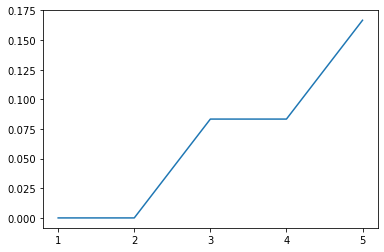

In [8]:
pmw(W_toy, x_toy) # run pmw using the toy datasets/queries from above

### Ex. 2. Identity Total Workload

original database: [2 0 0 1 0 1 2 0]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]], size = (9, 8)
error: [0.20833333 0.125      0.125      0.04166667 0.125      0.04166667
 0.20833333 0.125      0.        ]
relative error: [0.375   inf   inf 0.75    inf 0.75  0.375   inf 1.   ]
T (Threshold) = 20956.61047872099
query_answers (using pmw): [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 1.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 5.701862812424547. n is 6, and M is 8.
Update Count = 0

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


<ipython-input-7-f3f8ff4f363a>:80: RuntimeWarning: divide by zero encountered in true_divide
  relative_error = np.abs(query_answers / real_ans)


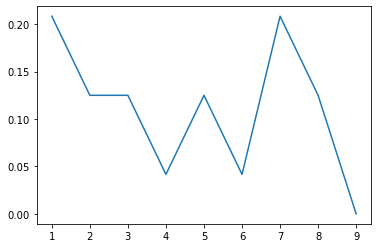

In [9]:
W1 = workload.IdentityTotal(8).dense_matrix()
pmw(W1, x_toy)

### Ex. 3. All Range Workload

original database: [2 0 0 1 0 1 2 0]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0.

<ipython-input-7-f3f8ff4f363a>:80: RuntimeWarning: divide by zero encountered in true_divide
  relative_error = np.abs(query_answers / real_ans)


T (Threshold) = 27412.890424602487
query_answers (using pmw): [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.125, 0.25, 0.375, 0.5, 0.625, 0.125, 0.25, 0.375, 0.5, 0.125, 0.25, 0.375, 0.125, 0.25, 0.125]

The update threshold for failure is n * math.log(M, 10)**(1/2): 5.701862812424547. n is 6, and M is 8.
Update Count = 0

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


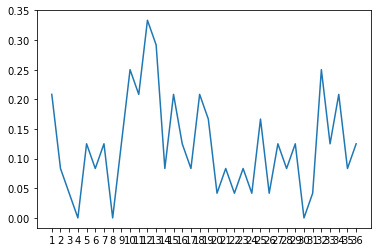

In [10]:
W2 = workload.AllRange(8).dense_matrix()
pmw(W2, x_toy)

### Ex. 4. H2 Workload

original database: [2 0 0 1 0 1 2 0]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]], size = (15, 8)
error: [0.20833333 0.125      0.125      0.04166667 0.125      0.04166667
 0.20833333 0.125      0.08333333 0.08333333 0.08333333 0.08333333
 0.         0.         0.        ]
relative error: [0.375   inf   inf 0.75    inf 0.75  0.375   inf 0.75  1.5   1.5   0.75
 1.    1.    1.   ]
T (Threshold) = 23335.638571930947
query_answers (using pmw): [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 1.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 5.701862812424547. n is

<ipython-input-7-f3f8ff4f363a>:80: RuntimeWarning: divide by zero encountered in true_divide
  relative_error = np.abs(query_answers / real_ans)


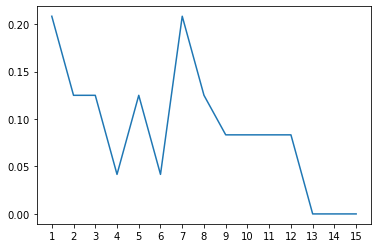

In [11]:
W3 = workload.H2(8).dense_matrix()
pmw(W3, x_toy)

## Ex. 5. Males in one year only

original database: [1000 1210    0 1250    0 1450    0 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.02309303 0.03527282 0.0314706  0.09823181 0.04072398]
relative error: [0.97690697 1.06758924 1.0848171  1.65127688 0.        ]
T (Threshold) = 2532.54871932831
query_answers (using pmw): [0.9769069663134385, 0.5571431050684563, 0.40251132136087636, 0.24906136977494453, 0.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 6300.558407729125. n is 6630, and M is 8.
Update Count = 3

Updated Database = [0.12453068 0.1227076  0.12453068 0.1227076  0.12638086 0.12638086
 0.12638086 0.12638086]


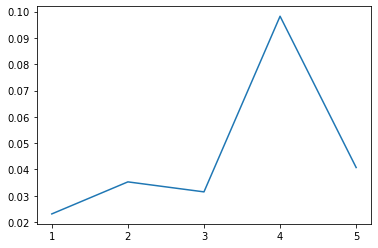

In [12]:
x_ex_5 = np.array([1000, 1210, 0, 1250, 0, 1450, 0, 1720])
pmw(W_toy, x_ex_5)

# 6/22

## 1. Variation in database size

original database: [10 12 13 12 15 14 17 17]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.         0.07272727 0.03181818 0.04090909 0.04545455]
relative error: [1.         1.17021277 1.14583333 1.19565217 0.        ]
T (Threshold) = 11194.451847388527
query_answers (using pmw): [1.0, 0.5, 0.25, 0.25, 0.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 104.5341515611167. n is 110, and M is 8.
Update Count = 0

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


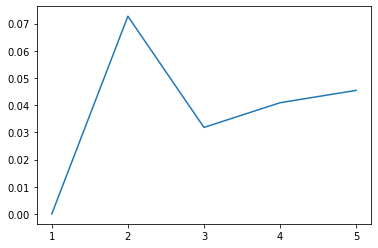

In [13]:
x_very_small = np.array([10, 12, 13, 12, 15, 14, 17, 17])
pmw(W_toy, x_very_small) 

original database: [100 121 130 125 150 145 170 172]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [1.11022302e-16 7.23270440e-02 2.89757412e-02 4.33513028e-02
 4.22282120e-02]
relative error: [1.         1.16911765 1.13109756 1.20978261 0.        ]
T (Threshold) = 5048.310562494652
query_answers (using pmw): [1.0, 0.5, 0.25, 0.25, 0.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 1057.6955517047536. n is 1113, and M is 8.
Update Count = 0

Updated Database = [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


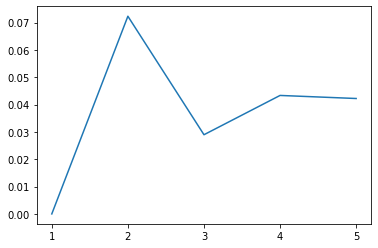

In [14]:
x_small = np.array([100, 121, 130, 125, 150, 145, 170, 172])
pmw(W_toy, x_small) 

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.00641434 0.00050004 0.00020306 0.04262982 0.04222821]
relative error: [0.99358566 0.99883079 0.9990813  1.20629126 0.        ]
T (Threshold) = 2057.1005089732066
query_answers (using pmw): [0.9935856636256851, 0.4271729183301192, 0.22082120324438007, 0.2492785176223226, 0.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 10576.955517047534. n is 11130, and M is 8.
Update Count = 3

Updated Database = [0.12463926 0.12322859 0.12463926 0.12322859 0.12606607 0.12606607
 0.12606607 0.12606607]


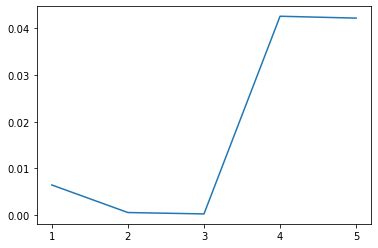

In [15]:
x_large = np.array([1000, 1210, 1300, 1250, 1500, 1450, 1700, 1720])
pmw(W_toy, x_large) 

original database: [10000 12100 13000 12500 15000 14500 17000 17200]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [7.69607893e-05 1.65778830e-03 8.44706079e-04 2.38826612e-05
 2.66722626e-04]
relative error: [0.99992304 0.9961237  1.00382178 1.00011557 0.99368378]
T (Threshold) = 792.6441448202266
query_answers (using pmw): [0.9999230392106773, 0.42601516767074077, 0.22186896483897417, 0.20667257987589155, -0.04196148941382601]

The update threshold for failure is n * math.log(M, 10)**(1/2): 105769.55517047535. n is 111300, and M is 8.
Update Count = 5

Updated Database = [0.12454966 0.12454966 0.12454966 0.12454966 0.12590189 0.12590189
 0.12499878 0.12499878]


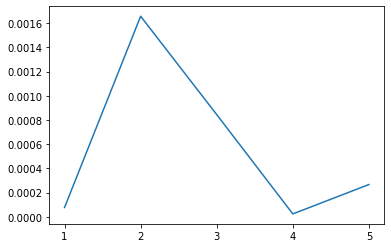

In [16]:
x_really_large = np.array([10000, 12100, 13000, 12500, 15000, 14500, 17000, 17200])
pmw(W_toy, x_really_large) 

original database: [ 5000  6100 13000  9500  8100  9000 12000 14000]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.00034434 0.00019703 0.0008121  0.00014737 0.00166026]
relative error: [1.00034434 0.99955023 0.99600715 1.00062795 1.0143081 ]
T (Threshold) = 927.3625170213256
query_answers (using pmw): [1.0003443437580386, 0.4378733751597055, 0.20257772642119953, 0.234827941053841, -0.11769676807015644]

The update threshold for failure is n * math.log(M, 10)**(1/2): 72888.81295216046. n is 76700, and M is 8.
Update Count = 5

Updated Database = [0.12445742 0.12445742 0.12445742 0.12445742 0.12608693 0.12608693
 0.12499823 0.12499823]


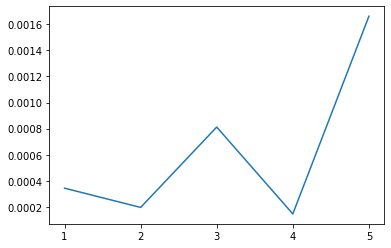

In [17]:
x_really_large_variant = np.array([5000, 6100, 13000, 9500, 8100, 9000, 12000, 14000])
pmw(W_toy, x_really_large_variant) 

Conclusion: Adding variation didn't really change much, x still isn't updating.

## 2. Variation in epsilon

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [2.14903771e-08 4.14729440e-09 4.19193102e-09 1.84698201e-08
 2.21228309e-08]
relative error: [0.99999998 0.99999999 1.00000002 1.00000009 1.00000052]
T (Threshold) = 0.0020571005089732065
query_answers (using pmw): [0.9999999785096227, 0.4276729518275484, 0.22102426295203884, 0.20664871568455503, -0.04222823416236374]

The update threshold for failure is n * math.log(M, 10)**(1/2): 10576.955517047534. n is 11130, and M is 8.
Update Count = 5

Updated Database = [0.1235732  0.1235732  0.1235732  0.1235732  0.1278658  0.1278658
 0.12498781 0.12498781]


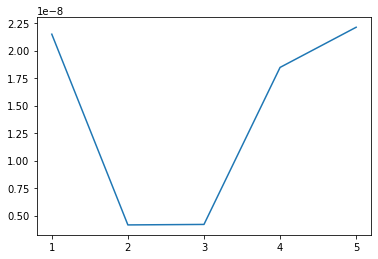

In [18]:
# massive epsilon
pmw(W_toy, x_large, eps=10000) 

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [2.64259842e-05 1.61468231e-05 1.68720261e-05 2.80011900e-05
 1.01599834e-05]
relative error: [1.00002643 0.99996224 0.99992366 1.0001355  0.9997594 ]
T (Threshold) = 1.6861479581747596
query_answers (using pmw): [1.0000264259841614, 0.4276568091517456, 0.22100738673400316, 0.2066766984047004, -0.0422180520561597]

The update threshold for failure is n * math.log(M, 10)**(1/2): 10576.955517047534. n is 11130, and M is 8.
Update Count = 5

Updated Database = [0.1235732  0.1235732  0.1235732  0.1235732  0.1278658  0.1278658
 0.12498781 0.12498781]


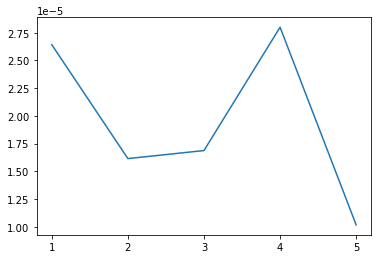

In [19]:
# huge epsilon
pmw(W_toy, x_large, eps=12.2) 

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [3.63279190e-05 2.41068549e-05 5.11417442e-06 1.62390707e-05
 1.68727804e-06]
relative error: [1.00003633 0.99994363 0.99997686 1.00007858 1.00003996]
T (Threshold) = 4.571334464384904
query_answers (using pmw): [1.0000363279189957, 0.4276488491199443, 0.22101914458568347, 0.20666493628542099, -0.042229899317572366]

The update threshold for failure is n * math.log(M, 10)**(1/2): 10576.955517047534. n is 11130, and M is 8.
Update Count = 5

Updated Database = [0.1235732  0.1235732  0.1235732  0.1235732  0.1278658  0.1278658
 0.12498781 0.12498781]


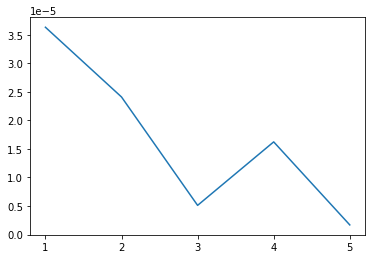

In [20]:
# large epsilon
pmw(W_toy, x_large, eps=4.5) 

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.00035369 0.000569   0.00197742 0.00092145 0.00068922]
relative error: [0.99964631 1.00133046 1.00894662 0.99554097 0.9836787 ]
T (Threshold) = 205.71005089732066
query_answers (using pmw): [0.9996463098908767, 0.4282419573776891, 0.22300167853120895, 0.20572724428036102, -0.04153899269244386]

The update threshold for failure is n * math.log(M, 10)**(1/2): 10576.955517047534. n is 11130, and M is 8.
Update Count = 5

Updated Database = [0.1235732  0.1235732  0.1235732  0.1235732  0.1278658  0.1278658
 0.12498781 0.12498781]


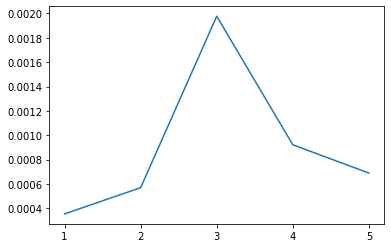

In [21]:
# medium epsilon
pmw(W_toy, x_large, eps=0.1) 

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1 -1 -1]], size = (5, 8)
error: [0.00120061 0.03292929 0.00920124 0.00436173 0.04222821]
relative error: [0.99879939 0.92300357 1.04163001 0.97889302 0.        ]
T (Threshold) = 2057.1005089732066
query_answers (using pmw): [0.9987993877051697, 0.3947436635308726, 0.2302255009979499, 0.20228696754951575, 0.0]

The update threshold for failure is n * math.log(M, 10)**(1/2): 10576.955517047534. n is 11130, and M is 8.
Update Count = 4

Updated Database = [0.12357724 0.12357724 0.12357724 0.12357724 0.12642276 0.12642276
 0.12642276 0.12642276]


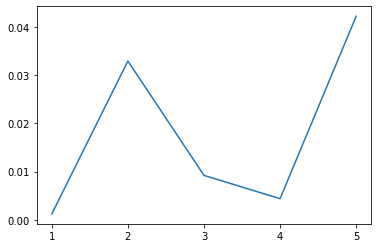

In [22]:
# small epsilon
pmw(W_toy, x_large, eps=0.01) 

## 2. Sparse-Dense

In [23]:
W_identity = workload.Identity(8).dense_matrix()
W_allrange = workload.AllRange(8).dense_matrix()
W_total = workload.Total(8).dense_matrix()

### 5 identity matrices

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1.

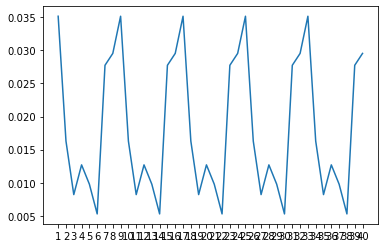

In [24]:
W_five_identity = np.vstack((W_identity, W_identity, W_identity, W_identity, W_identity))
pmw(W_five_identity, x_large) 

### Sparse -> Dense

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0.

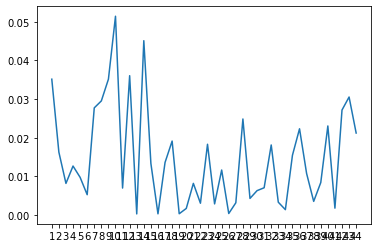

In [25]:
W_sd = np.vstack((W_identity, W_allrange))
pmw(W_sd, x_large) 

### Dense -> Sparse

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0.

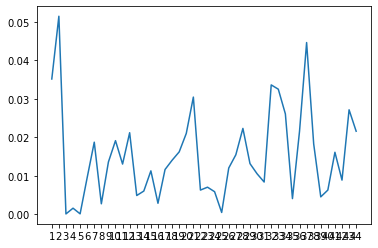

In [26]:
W_ds = np.vstack((W_allrange, W_identity))
pmw(W_ds, x_large) 

### Sparse -> Dense -> Sparse

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0.

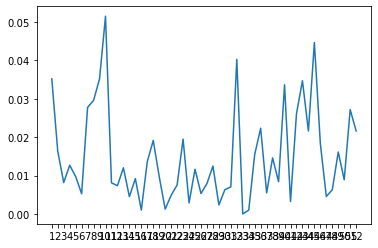

In [27]:
W_sds = np.vstack((W_identity, W_allrange, W_identity))
pmw(W_sds, x_large) 

### Dense -> Sparse -> Dense

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0.

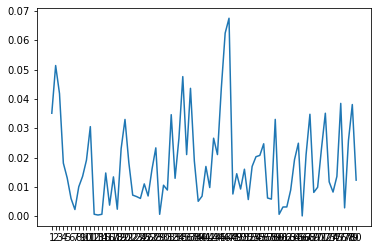

In [28]:
W_dsd = np.vstack((W_allrange, W_identity, W_allrange))
pmw(W_dsd, x_large) 

### Randomized

original database: [1000 1210 1300 1250 1500 1450 1700 1720]
workload: 
[[0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0.

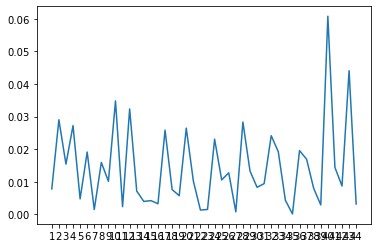

In [29]:
W_random = np.random.permutation(W_sd)
pmw(W_random, x_large) 

## 4. Try Non-Smooth Databases

## 5. Assess effects on Analysts

- fix update count to test extreme cases - is n 1? or is n the length of the dataset instead?
- can we talk about smooth vs. non smooth databases
- do i begin graphing things?

https://pdfs.semanticscholar.org/90dd/0d2404cce76688945ba894670401698885c6.pdf